In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from IPython.display import clear_output

/root/anaconda3/envs/pytorch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Импортируем датасет MNIST

In [2]:
training_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
)

## Визуализуруем данные

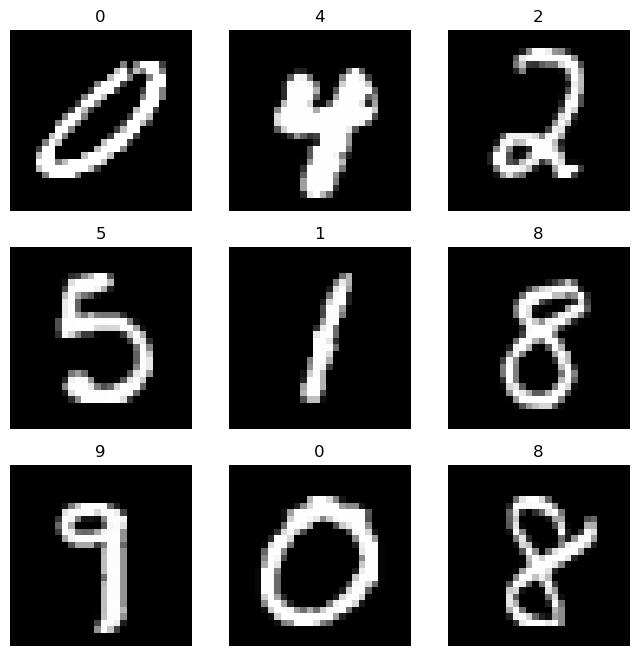

In [3]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size = (1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Создаем DataLoders

In [4]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


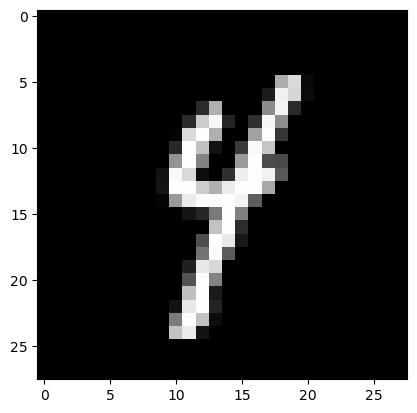

Label: 4


In [5]:
# display image and labels
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Создаем модель

In [6]:
from torch import nn

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [8]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Инициализируем гиперпараметры

In [15]:
learning_rate = 1e-3
batch_size = 64
epochs = 10

## Задаем функию потерь

In [16]:
loss_fn = nn.CrossEntropyLoss()

## Функция оптимизации

In [17]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Циклы обучения и проверки

In [18]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch % 100 == 0:
           loss, current = loss.item(), batch * batch_size + len(X)
           print(f"Loss: {loss:>7f} [{current:>5d}/{size:>5d}]\n")

test_losses = []
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= num_batches
        correct /= size
        test_losses.append(test_loss)
    clear_output(wait=True)
    plt.plot(test_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Avg Loss')
    plt.show()

    print(f"Accurasy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

## Обучение

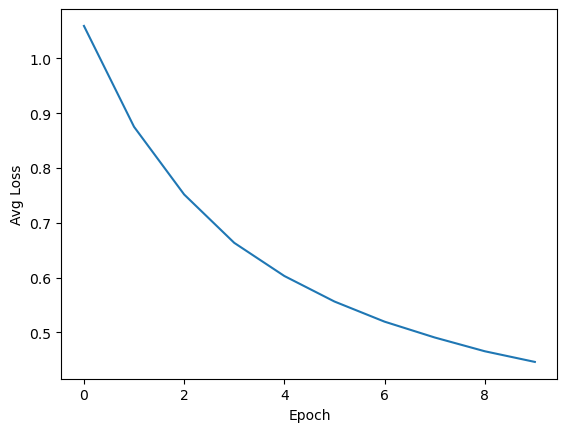

Accurasy: 88.1%, Avg loss: 0.446177 



In [19]:
for t in range(1, epochs + 1):
    print(f"Epoch: {t}\n-------------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
    if t % 10 == 0:
        torch.save(model.state_dict(), 'model_weights.pth')

## Ручная проверка модели

In [21]:
saved_weights = torch.load('model_weights.pth')
model.load_state_dict(saved_weights)
model.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

Predicted label: 1, True lable: 1


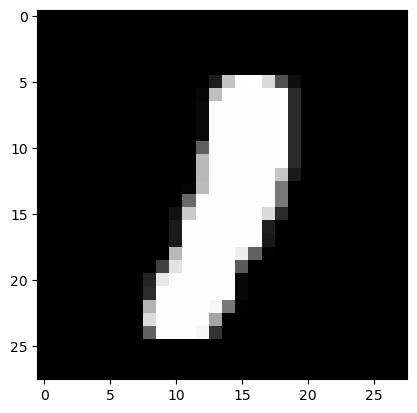

In [42]:
sample_idx = torch.randint(len(test_data), size=(1,)).item()
random_img, label = test_data[sample_idx]
plt.imshow(random_img.squeeze(), cmap='gray')
print(f"Predicted label: {model(random_img).argmax(1).sum()}, True lable: {label}")